In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import time
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
# Definir el generador y el discriminador
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
            nn.Sigmoid()
                    

        )
        
    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
            

        )
        
    def forward(self, x):
        return self.net(x)
        
# Leer datos
expression_data = pd.read_csv('exprTRAIN.csv')
methylation_data = pd.read_csv('methylTRAIN.csv')
assign_data = pd.read_csv('assignTRAIN.csv')

expression_data = expression_data.iloc[:, 1:]
methylation_data = methylation_data.iloc[:, 1:]
assign_data = assign_data.iloc[:, 2:]

# Convertir todas las columnas a tipo float
expression_data = expression_data.apply(pd.to_numeric, errors='coerce')
methylation_data = methylation_data.apply(pd.to_numeric, errors='coerce')
assign_data = assign_data.apply(pd.to_numeric, errors='coerce')
# Lidiar con valores NaN (si los hay). Pone 0(CAMBIAR)
expression_data.fillna(0, inplace=True)
methylation_data.fillna(0, inplace=True)
assign_data.fillna(0, inplace=True)

expression_data = expression_data.values
methylation_data = methylation_data.values
assign_data=assign_data.values
# Asegurar que tienes el mismo número de muestras en ambos conjuntos de datos


assert expression_data.shape[0] == methylation_data.shape[0], "Los datos de expresión y metilación deben tener el mismo número de muestras."
assert assign_data.shape[0] == methylation_data.shape[0], "Los datos de asignación y metilación deben tener el mismo número de muestras."

# Concatenar los datos
#combined_data =torch.FloatTensor(np.hstack((expression_data, methylation_data,assign_data)))
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device="cpu"
expression_data = torch.FloatTensor(expression_data).to(device)
methylation_data = torch.FloatTensor(methylation_data).to(device)
assign_data = torch.FloatTensor(assign_data).to(device)
combined_data = torch.cat((expression_data,methylation_data,assign_data), 1).to(device)

True


In [2]:





# Modelos y optimizadores
gen = Generator(expression_data.shape[1], methylation_data.shape[1]+assign_data.shape[1]).to(device)
disc = Discriminator(expression_data.shape[1] + methylation_data.shape[1]+assign_data.shape[1]).to(device)
print(f'El modelo Generator tiene {count_parameters(gen)} parámetros entrenables.')
print(f'El modelo Discriminator tiene {count_parameters(disc)} parámetros entrenables.')
gen_optimizer = optim.RMSprop(gen.parameters(), lr=0.0002)
disc_optimizer = optim.RMSprop(disc.parameters(), lr=0.0002)
criterion = nn.BCELoss()
mse_criterion = nn.MSELoss(reduction='sum')
# Entrenamiento
n_samples = combined_data.size(0)
batch_size = 64
n_epochs = 10000
start_time = time.time()
for epoch in range(n_epochs):
    for idx in range(0, n_samples, batch_size):
        real_data = combined_data[idx:idx+batch_size].to(device)
        current_batch_size = real_data.size(0)
        real_labels = torch.ones(current_batch_size, 1).to(device)

        #noise = torch.randn(current_batch_size, 100).to(device)
        noise = expression_data[idx:idx+batch_size]
        
        fake_methyl = gen(noise).to(device)
        #fake_data = torch.cat((expression_data[idx:idx+batch_size],fake_methyl), 1)

        fake_data = torch.cat((expression_data[idx:idx+batch_size],fake_methyl ), 1).to(device)

        fake_labels = torch.zeros(current_batch_size, 1).to(device)
        
        # Entrenar discriminador
        disc_optimizer.zero_grad()

        real_preds = disc(real_data).to(device)
        real_loss = criterion(real_preds, real_labels)
        
        fake_preds = disc(fake_data).to(device)
        fake_loss = criterion(fake_preds, fake_labels)

        disc_loss = real_loss + fake_loss
        disc_loss.backward()
        disc_optimizer.step()

        # Entrenar generador
        gen_optimizer.zero_grad()

        #noise = torch.randn(current_batch_size, 100).to(device)
        noise = expression_data[idx:idx+batch_size]
        fake_methyl = gen(noise).to(device)
        fake_data = torch.cat((expression_data[idx:idx+batch_size],fake_methyl ), 1).to(device)
        fake_preds = disc(fake_data).to(device)


        # Loss basado en la capacidad de engañar al discriminador
        gan_loss = criterion(fake_preds, real_labels)

        # MSE loss entre el metilación generado y el metilación real
        mse_loss = mse_criterion(fake_methyl,  torch.cat((methylation_data[idx:idx+batch_size],assign_data[idx:idx+batch_size]),1).to(device))

        # Combina ambos losses. El coeficiente 'alpha' permite ponderar la importancia relativa de cada loss.
        alpha = 1.5
        gen_loss = gan_loss + alpha * mse_loss

        gen_loss.backward()
        gen_optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} | Disc Loss: {disc_loss.item()} | Gen Loss: {gen_loss.item()}| Gan Loss: {gan_loss.item()}| Mse Loss: {mse_loss.item()}")
        end_time = time.time()

        # Calcular la diferencia de tiempo
        elapsed_time = end_time - start_time

        print(f"El código tardó {elapsed_time:.5f} segundos en ejecutarse.")
        start_time = time.time()

torch.save(gen.state_dict(), 'generator_model4.pth')




El modelo Generator tiene 144496 parámetros entrenables.
El modelo Discriminator tiene 226817 parámetros entrenables.


KeyboardInterrupt: 

In [4]:
import torch
import pandas as pd
from sklearn.metrics import mean_squared_error
from torch.nn.functional import mse_loss

# Leer datos
expression_data2 = pd.read_csv('exprTEST.csv')
methylation_data2 = pd.read_csv('methylTEST.csv')
assign_data2 = pd.read_csv('assignTEST.csv')

expression_data2 = expression_data2.iloc[:, 1:]
methylation_data2 = methylation_data2.iloc[:, 1:]
assign_data2 = assign_data2.iloc[:, 2:]

# Convertir todas las columnas a tipo float
expression_data2 = expression_data2.apply(pd.to_numeric, errors='coerce')
methylation_data2 = methylation_data2.apply(pd.to_numeric, errors='coerce')
assign_data2 = assign_data2.apply(pd.to_numeric, errors='coerce')
# Lidiar con valores NaN (si los hay). Pone 0(CAMBIAR)
expression_data2.fillna(0, inplace=True)
methylation_data2.fillna(0, inplace=True)
assign_data2.fillna(0, inplace=True)

expression_data2 = expression_data2.values
methylation_data2 = methylation_data2.values
assign_data2=assign_data2.values
# Asegurar que tienes el mismo número de muestras en ambos conjuntos de datos


assert expression_data2.shape[0] == methylation_data2.shape[0], "Los datos de expresión y metilación deben tener el mismo número de muestras."
assert assign_data2.shape[0] == methylation_data2.shape[0], "Los datos de asignación y metilación deben tener el mismo número de muestras."

# Concatenar los datos
#combined_data =torch.FloatTensor(np.hstack((expression_data, methylation_data,assign_data)))
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device="cpu"
expression_data2 = torch.FloatTensor(expression_data2).to(device)
methylation_data2 = torch.FloatTensor(methylation_data2).to(device)
assign_data2 = torch.FloatTensor(assign_data2).to(device)
combined_data2= torch.cat((expression_data2,methylation_data2,assign_data2), 1).to(device)
# Carga del modelo previamente entrenado
gen = Generator(expression_data2.shape[1], methylation_data2.shape[1]+assign_data2.shape[1])
gen.load_state_dict(torch.load('generator_model4.pth'))
gen.eval()
gen.to(device)

# Pasar todos los datos de expr.csv a través del generador
with torch.no_grad():
    generated_methyl = gen(expression_data2)

# Asegúrate de que los datos generados y los datos reales estén en la misma forma
generated_methyl = generated_methyl.cpu().numpy()

# Aquí estamos asumiendo que la primera parte de la salida generada corresponde a methyl.csv
# Si tu salida generada incluye más datos además de methyl.csv, necesitas ajustar esto
generated_methyl_data = generated_methyl[:, :methylation_data2.shape[1]]

# Calcula el error cuadrático medio entre los datos generados y los reales
mse = mean_squared_error(methylation_data2.cpu().numpy(), generated_methyl_data)
print(f"Error cuadrático medio entre datos generados y reales: {mse}")
print(f"Media: {methylation_data2.mean()}")
# Si el MSE es bajo, significa que los datos generados y los datos reales son muy similares.

individual_mse_errors = []

# Procesar datos
with torch.no_grad():
    for i in range(expression_data2.shape[0]):
        input_expr = expression_data2[i].unsqueeze(0)  # Añadir dimensión de batch
        real_output = torch.cat([methylation_data2[i], assign_data2[i]]).unsqueeze(0)  # Añadir dimensión de batch
        generated_output = gen(input_expr)
        
        error = mse_loss(generated_output, real_output)
        #print(generated_output)
        #print(real_output)
        individual_mse_errors.append(error.item())

# Si deseas, puedes imprimir el error MSE para cada fila
for i, error in enumerate(individual_mse_errors):
    print(f"Fila {i + 1}: MSE = {error}")

True
Error cuadrático medio entre datos generados y reales: 0.43134647607803345
Media: 0.3579321503639221
Fila 1: MSE = 0.4896969795227051
Fila 2: MSE = 0.21733097732067108
Fila 3: MSE = 0.4956974387168884
Fila 4: MSE = 0.5466692447662354
Fila 5: MSE = 0.5382905602455139
Fila 6: MSE = 0.513444721698761
Fila 7: MSE = 0.41895535588264465
Fila 8: MSE = 0.554523766040802
Fila 9: MSE = 0.4265422821044922
Fila 10: MSE = 0.5008180141448975
Fila 11: MSE = 0.49903497099876404
Fila 12: MSE = 0.445203959941864
Fila 13: MSE = 0.39862194657325745
Fila 14: MSE = 0.5037850737571716
Fila 15: MSE = 0.4815906882286072
Fila 16: MSE = 0.4513627290725708
Fila 17: MSE = 0.42977309226989746
Fila 18: MSE = 0.4835289716720581
Fila 19: MSE = 0.34101179242134094
Fila 20: MSE = 0.5161104202270508
Fila 21: MSE = 0.25934353470802307
Fila 22: MSE = 0.49785101413726807
Fila 23: MSE = 0.26259908080101013
Fila 24: MSE = 0.4871164560317993
Fila 25: MSE = 0.4957050681114197
Fila 26: MSE = 0.45524799823760986
Fila 27: MSE

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Generar datos de expresión sintética
gen2 = Generator(expression_data.shape[1], methylation_data.shape[1]+assign_data.shape[1]).to(device)
gen2.load_state_dict(torch.load('generator_model2.pth'))
gen2.eval()
expressions_list = []
for i in range(100000):
    noise = torch.randn(1, expression_data.shape[1]).to(device)
    synthetic_expression = gen2(noise).to(device)
    #print(synthetic_expression)
    expressions_list.append(synthetic_expression.detach().cpu().numpy().squeeze())

X = pd.DataFrame(expressions_list)
#X = X.apply(pd.to_numeric, errors='coerce')
y = X.iloc[:, -1].values.astype(int)  # Suponiendo que la asignación está en la primera columna

X = X.iloc[:, :-1]
# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenamos el modelo SVC
clf = SVC()
clf.fit(X_train, y_train)

# Predicciones
y_pred = clf.predict(X_test)

# Métricas de clasificación
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

ValueError: The number of classes has to be greater than one; got 1 class

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     23934
           2       1.00      1.00      1.00      6066

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000



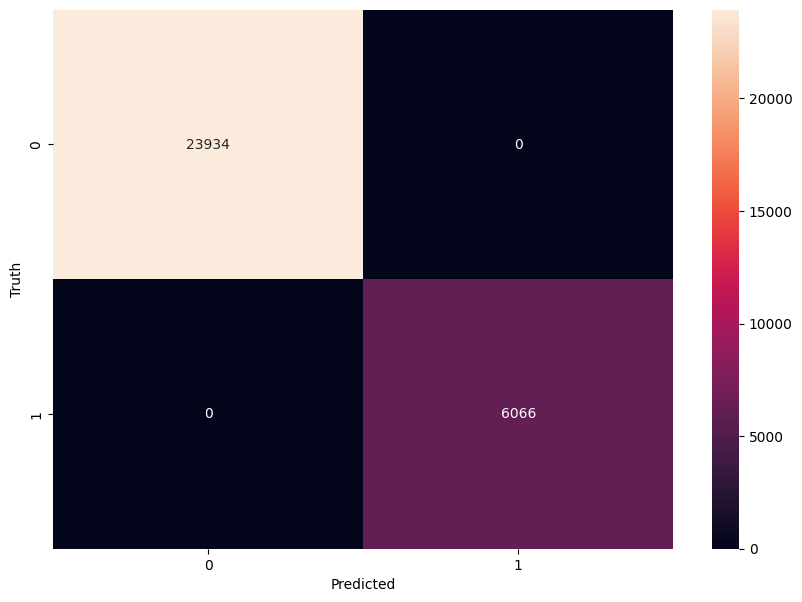

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Cargamos los datos
expr_data = pd.read_csv('exprMID.csv')
meth_data = pd.read_csv('methylMID.csv')
assig_data = pd.read_csv('assignMID.csv')
expr_data = expr_data.iloc[:, 1:]
meth_data = meth_data.iloc[:, 1:]
assig_data = assig_data.iloc[:, 2:]

# Convertir todas las columnas a tipo float
expr_data = expr_data.apply(pd.to_numeric, errors='coerce')
meth_data = meth_data.apply(pd.to_numeric, errors='coerce')
assig_data = assig_data.apply(pd.to_numeric, errors='coerce')
# Lidiar con valores NaN (si los hay). Pone 0(CAMBIAR)
expr_data.fillna(0, inplace=True)
meth_data.fillna(0, inplace=True)
assig_data.fillna(0, inplace=True)
# Aseguramos que las dimensiones coincidan
assert expr_data.shape[0] == meth_data.shape[0] == assig_data.shape[0], "Las dimensiones de los archivos no coinciden"

# Combinamos los datos de expresión génica y metilación
X = pd.concat([expr_data, meth_data], axis=1)
y = assig_data.iloc[:, 0].values  # Suponiendo que la asignación está en la primera columna

# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenamos el modelo SVC
clf = SVC()
clf.fit(X_train, y_train)

# Predicciones
y_pred = clf.predict(X_test)

# Métricas de clasificación
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


              precision    recall  f1-score   support

           1       1.00      1.00      1.00     23934
           2       1.00      1.00      1.00      6066

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000



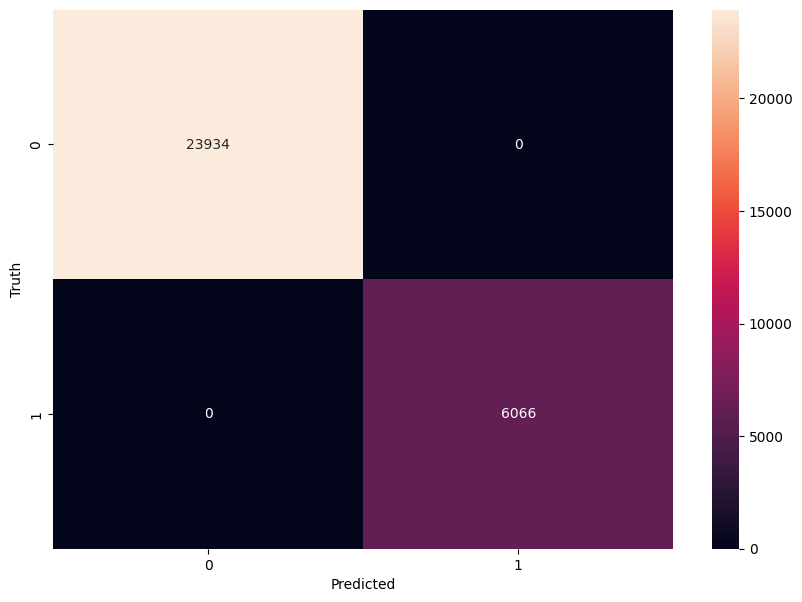

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Cargamos los datos
expr_data = pd.read_csv('exprMID.csv')
meth_data = pd.read_csv('methylMID.csv')
assig_data = pd.read_csv('assignMID.csv')
expr_data = expr_data.iloc[:, 1:]
meth_data = meth_data.iloc[:, 1:]
assig_data = assig_data.iloc[:, 2:]

# Convertir todas las columnas a tipo float
expr_data = expr_data.apply(pd.to_numeric, errors='coerce')
meth_data = meth_data.apply(pd.to_numeric, errors='coerce')
assig_data = assig_data.apply(pd.to_numeric, errors='coerce')
# Lidiar con valores NaN (si los hay). Pone 0(CAMBIAR)
expr_data.fillna(0, inplace=True)
meth_data.fillna(0, inplace=True)
assig_data.fillna(0, inplace=True)
# Aseguramos que las dimensiones coincidan
assert expr_data.shape[0] == meth_data.shape[0] == assig_data.shape[0], "Las dimensiones de los archivos no coinciden"

# Combinamos los datos de expresión génica y metilación
X = meth_data
y = assig_data.iloc[:, 0].values  # Suponiendo que la asignación está en la primera columna

# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenamos el modelo SVC
clf = SVC()
clf.fit(X_train, y_train)

# Predicciones
y_pred = clf.predict(X_test)

# Métricas de clasificación
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()
